In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
from model import CNN_Simulator

from evolution import Enviroment, Species

import multilayer as ml
from utils import tensor_2_numpy, numpy_2_tensor

In [2]:
# load simulator
device = 'cuda:1'
batchsize = 16
model_path = './model/CNN_simulator.pth'
simulator = CNN_Simulator(25, 4832)
simulator.load_state_dict(torch.load(model_path))
simulator.to(device)
simulator.eval()

CNN_Simulator(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convs_1): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (convs_2): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (convs_3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (layer1): Linear(in_features=4672, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=256, bias=True)
  (layer4): Linear(in_features=256, out_features=512, bias=True)
  (layer5): Linear(in_features=512, out_features=4832, bias=True)
  (ReLU): ReLU()
)


CNN_Simulator(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convs_1): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (convs_2): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (convs_3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (layer1): Linear(in_features=4672, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=256, bias=True)
  (layer4): Linear(in_features=256, out_features=512, bias=True)
  (layer5): Linear(in_features=512, out_features=4832, bias=True)
  (ReLU): ReLU()
)

In [110]:
# define fitness function

def fitness_fn(species_list, spacing_list):
    # load SU-8-air interface parameters
    data_top = np.loadtxt('./data/0.txt')
    S_matrix_top = ml.get_S_coefficients(data_top, with_freq=True)
    M_matrix_top = ml.S_to_M(S_matrix_top)
    
    # defined constants
    freqs = data_top[:,0] * 1e12
    lambs = 3e8 / freqs
    k0s = 2*np.pi / lambs
    n = 1.5
    
    # initialize
    if len(spacing_list.shape) == 1:
        num_population = species_list[0].population_size
    elif len(spacing_list.shape) == 2:
        num_population = spacing_list.shape[0]
        
    S_matrices_list = [] # store S_matrices for each 
    
    def combine_simulate(species_list, spacing_list):
        if len(spacing_list.shape) == 1:
            for i in range(num_population):
                all_M_matrix = [M_matrix_top]
                for j, sp in enumerate(species_list):
                    spacing = spacing_list[j] * 1e-9
                    P_matrix = ml.propagation_matrix(n, spacing, k0s)
                    S_matrix = ml.get_S_coefficients(sp.S_data[i])
                    all_M_matrix.append(P_matrix)
                    all_M_matrix.append(ml.S_to_M(S_matrix))
                # compute 
                all_M_matrix.reverse() # reverse since the calculation is from top to down
                all_M = ml.combine_layers(all_M_matrix)
                all_S_matrix = ml.M_to_S(all_M)
                S_matrices_list.append(all_S_matrix)   
                
        elif len(spacing_list.shape) == 2:
            for i in range(num_population):
                all_M_matrix = [M_matrix_top]
                for j, sp in enumerate(species_list):
                    spacing = spacing_list[i,j] * 1e-9
                    P_matrix = ml.propagation_matrix(n, spacing, k0s)
                    S_matrix = ml.get_S_coefficients(sp.optim_S_data)
                    all_M_matrix.append(P_matrix)
                    all_M_matrix.append(ml.S_to_M(S_matrix))
                # compute 
                all_M_matrix.reverse() # reverse since the calculation is from top to down
                all_M = ml.combine_layers(all_M_matrix)
                all_S_matrix = ml.M_to_S(all_M)
                S_matrices_list.append(all_S_matrix)
            
    combine_simulate(species_list, spacing_list)
    
    
    ###########################################################################
    # define objectives here
    Txxs = np.array([S_matrices_list[i]['Txx_a'] for i in range(num_population)])
    Tyys = np.array([S_matrices_list[i]['Tyy_a'] for i in range(num_population)])
    Txys = np.array([S_matrices_list[i]['Txy_a'] for i in range(num_population)])
    Tyxs = np.array([S_matrices_list[i]['Tyx_a'] for i in range(num_population)])
    Rxxs = np.array([S_matrices_list[i]['Rxx_b'] for i in range(num_population)])
    Ryys = np.array([S_matrices_list[i]['Ryy_b'] for i in range(num_population)])
    Rxys = np.array([S_matrices_list[i]['Rxy_b'] for i in range(num_population)])
    Ryxs = np.array([S_matrices_list[i]['Ryx_b'] for i in range(num_population)])

    objective_zeros = np.zeros(151)
    objective_ones = np.ones(151)
    
#     objective_Tyxs[50:120] = 0
    scores =  np.mean(np.abs(np.abs(Txys)-objective_ones)[:,55:100], 1)
#     scores = - np.mean(np.abs(np.abs(Txxs) - np.abs(Tyys))[:,40:80], 1)
#     scores = - np.mean(np.abs(np.abs(Txys) - np.abs(Tyxs))[:,50:100], 1)
#     scores = - np.mean(np.abs(Rxys - Ryxs)[:,50:100], 1)
    ############################################################################
    
    return scores
    

In [122]:
# create enviroment and species
env = Enviroment(simulator=simulator, spacing_bound=(200, 1000), mutate_spacing=True, device='cuda:1')
species_list = [Species(population_size=100, elites_size=30) for i in range(3)]
spacing_list = [400, 400, 400]


In [123]:
env.evolve(fitness_fn=fitness_fn, species_list=species_list, spacing_list=spacing_list, max_loop=60)

Iteration: 10, current best score: 0.38656828410586946
Iteration: 20, current best score: 0.23854941535819496
Iteration: 30, current best score: 0.03972722924993454
Iteration: 40, current best score: 0.02281543292478523
Iteration: 50, current best score: 0.01916490712740811
Iteration: 60, current best score: 0.01887498555048341


(32, 151)
7.165722798655446e-07 2.0000000000000002e-07 2.0113078533669397e-07


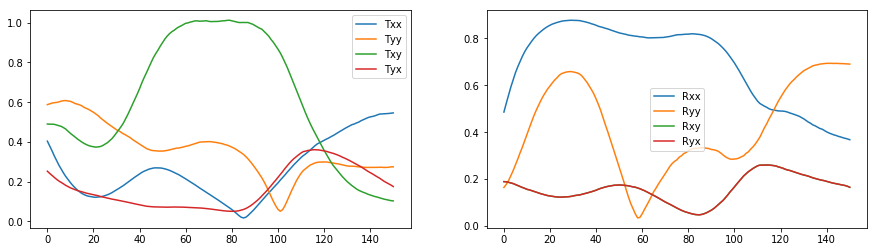

In [124]:
sp1 = species_list[0]
sp2 = species_list[1]
sp3 = species_list[2]
sp1_pop = sp1.population
sp2_pop = sp2.population
sp1_optim = sp1.optim_structure
sp2_optim = sp2.optim_structure
sp3_optim = sp3.optim_structure

sp1_s_data = tensor_2_numpy(simulator(numpy_2_tensor(sp1_optim.reshape((1, 1, 5, 5)), device=device))).reshape((32, -1))
sp2_s_data = tensor_2_numpy(simulator(numpy_2_tensor(sp2_optim.reshape((1, 1, 5, 5)), device=device))).reshape((32, -1))
sp3_s_data = tensor_2_numpy(simulator(numpy_2_tensor(sp3_optim.reshape((1, 1, 5, 5)), device=device))).reshape((32, -1))

s1_matrix = ml.get_S_coefficients(np.transpose(sp1_s_data))
s2_matrix = ml.get_S_coefficients(np.transpose(sp2_s_data))
s3_matrix = ml.get_S_coefficients(np.transpose(sp3_s_data))


s1_matrix = ml.get_S_coefficients(sp1.optim_S_data)
s2_matrix = ml.get_S_coefficients(sp2.optim_S_data)
s3_matrix = ml.get_S_coefficients(sp3.optim_S_data)
# print(s1_matrix['Txx_a'].shape)

m1, m2, m3 = ml.S_to_M(s1_matrix), ml.S_to_M(s2_matrix), ml.S_to_M(s3_matrix)


data_top = np.loadtxt('./data/0.txt')
s_top = ml.get_S_coefficients(data_top, with_freq=True)
m0 = ml.S_to_M(s_top)
freqs = data_top[:,0] * 1e12
lambs = 3e8 / freqs

n = 1.5
d1, d2, d3 = np.array(env.spacing_list) * 1e-9
k0s = 2*np.pi / lambs
P1, P2, P3 = ml.propagation_matrix(n, d1, k0s), ml.propagation_matrix(n, d2, k0s), ml.propagation_matrix(n, d3, k0s)
print(sp1_s_data.shape)
all_M_matrix = [m3, P3, m2, P2, m1, P1, m0]
all_M = ml.combine_layers(all_M_matrix)
s_matrix = ml.M_to_S(all_M)
plt.figure(figsize=[15,4])
plt.subplot(1,2,1)
plt.plot(np.abs(s_matrix['Txx_a']), label='Txx')
plt.plot(np.abs(s_matrix['Tyy_a']), label='Tyy')
plt.plot(np.abs(s_matrix['Txy_a']), label='Txy')
plt.plot(np.abs(s_matrix['Tyx_a']), label='Tyx')
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.abs(s_matrix['Rxx_b']), label='Rxx')
plt.plot(np.abs(s_matrix['Ryy_b']), label='Ryy')
plt.plot(np.abs(s_matrix['Rxy_b']), label='Rxy')
plt.plot(np.abs(s_matrix['Ryx_b']), label='Ryx')
# plt.plot(np.abs(s_matrix['Txx_c']), label='Txx_c')
# plt.plot(np.abs(s_matrix['Tyy_c']), label='Tyy_c')
plt.legend()
# plt.ylim([0,1])
print(d1, d2, d3)



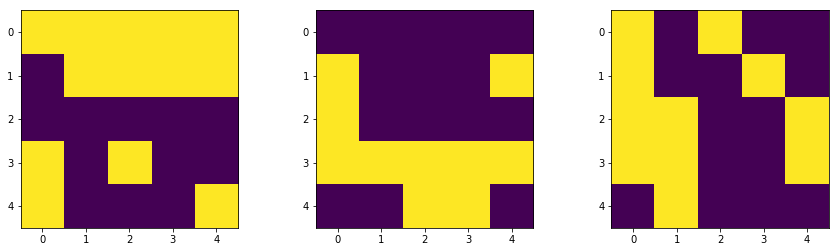

In [125]:
plt.figure(figsize=[15,4])
plt.subplot(1,3,1)
plt.imshow(sp1.optim_structure.reshape((5,5)))
plt.subplot(1,3,2)
plt.imshow(sp2.optim_structure.reshape((5,5)))
plt.subplot(1,3,3)
plt.imshow(sp3.optim_structure.reshape((5,5)))

(0, 1)

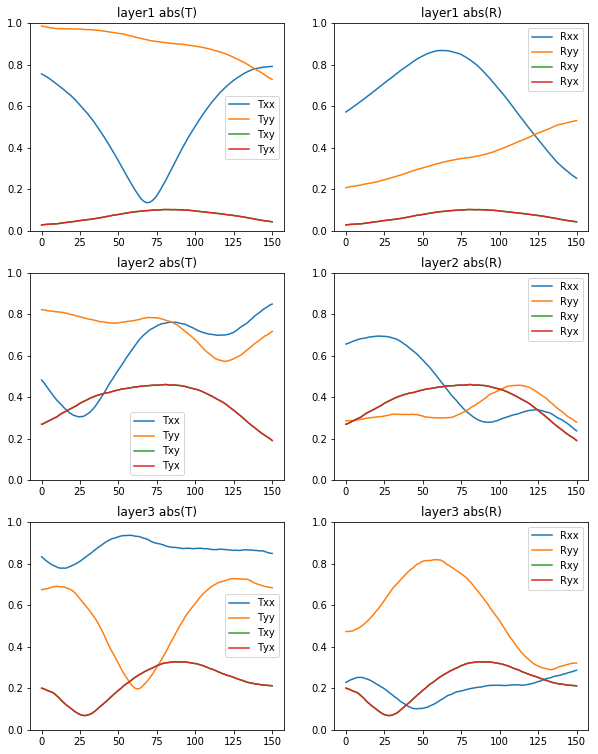

In [126]:
plt.figure(figsize=[10,13])
plt.subplot(3,2,1)
plt.plot(np.abs(s1_matrix['Txx_a']), label='Txx')
plt.plot(np.abs(s1_matrix['Tyy_a']), label='Tyy')
plt.plot(np.abs(s1_matrix['Txy_a']), label='Txy')
plt.plot(np.abs(s1_matrix['Tyx_a']), label='Tyx')
plt.legend()
plt.title('layer1 abs(T)')
plt.ylim([0,1])
plt.subplot(3,2,2)
plt.plot(np.abs(s1_matrix['Rxx_b']), label='Rxx')
plt.plot(np.abs(s1_matrix['Ryy_b']), label='Ryy')
plt.plot(np.abs(s1_matrix['Rxy_b']), label='Rxy')
plt.plot(np.abs(s1_matrix['Ryx_b']), label='Ryx')
plt.legend()
plt.title('layer1 abs(R)')
plt.ylim([0,1])
plt.subplot(3,2,3)
plt.plot(np.abs(s2_matrix['Txx_a']), label='Txx')
plt.plot(np.abs(s2_matrix['Tyy_a']), label='Tyy')
plt.plot(np.abs(s2_matrix['Txy_a']), label='Txy')
plt.plot(np.abs(s2_matrix['Tyx_a']), label='Tyx')
plt.legend()
plt.ylim([0,1])
plt.title('layer2 abs(T)')
plt.subplot(3,2,4)
plt.plot(np.abs(s2_matrix['Rxx_b']), label='Rxx')
plt.plot(np.abs(s2_matrix['Ryy_b']), label='Ryy')
plt.plot(np.abs(s2_matrix['Rxy_b']), label='Rxy')
plt.plot(np.abs(s2_matrix['Ryx_b']), label='Ryx')
plt.legend()
plt.title('layer2 abs(R)')
plt.ylim([0,1])
plt.subplot(3,2,5)
plt.plot(np.abs(s3_matrix['Txx_a']), label='Txx')
plt.plot(np.abs(s3_matrix['Tyy_a']), label='Tyy')
plt.plot(np.abs(s3_matrix['Txy_a']), label='Txy')
plt.plot(np.abs(s3_matrix['Tyx_a']), label='Tyx')
plt.legend()
plt.title('layer3 abs(T)')
plt.ylim([0,1])
plt.subplot(3,2,6)
plt.plot(np.abs(s3_matrix['Rxx_b']), label='Rxx')
plt.plot(np.abs(s3_matrix['Ryy_b']), label='Ryy')
plt.plot(np.abs(s3_matrix['Rxy_b']), label='Rxy')
plt.plot(np.abs(s3_matrix['Ryx_b']), label='Ryx')
plt.legend()
plt.title('layer3 abs(R)')
plt.ylim([0,1])